In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import LogRegAC.logRegAC as logRegAC
import LogRegAC.utilsAC as utilsAC
import LogRegAC.crossValdAC as crossValdAC

In [2]:
data = pd.read_csv('data.csv', header=None)
print(data.shape)
data.head()

(200, 3)


,0,1,2
0,6,32,1
1,26,39,1
2,2,38,1
3,25,39,1
4,3,35,1


In [3]:
data = data.sample(frac=1).reset_index(drop=True)
data_x = data.iloc[:, 0:-1]
data_y = data.iloc[:, -1].replace(-1, 0)

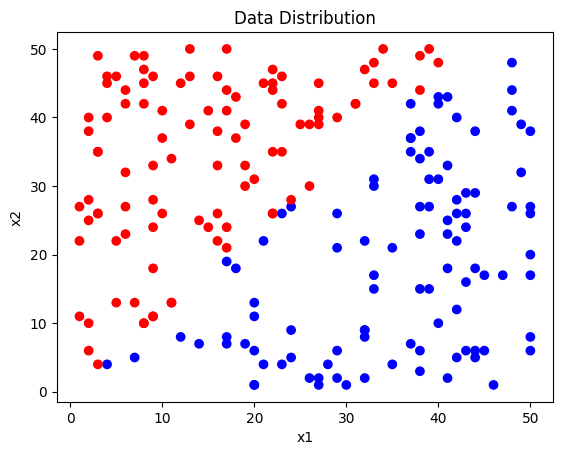

In [4]:
fig = plt.figure()
plt.scatter(data_x.iloc[:, 0], data_x.iloc[:, 1], c=data_y.map({0: 'blue', 1: 'red'}), marker='o')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Data Distribution')
plt.show()
fig.savefig('plots/data_dist.png')

In [5]:
train_x, train_y, test_x, test_y = utilsAC.splitTrainTest(data_x, data_y, 0.8)
train_x, train_min, train_max = utilsAC.normMinMax(train_x, mode='train')
test_x = utilsAC.normMinMax(test_x, mode='test', train_min=train_min, train_max=train_max)

## Newton's Method

In [6]:
nwt = logRegAC.LogReg(max_iter=500, eps=1e-5, newton=True)
t_beta = nwt.fit(train_x, train_y, iter_step=50, reg_term=1)
nwt_pred = nwt.predict(test_x)
print('F1 Score: ', utilsAC.get_performance_measure(test_y, nwt_pred)['f1'])

Implementing Newton's Method.
Iteration     0 | Cost:  131.930
Iteration    50 | Cost:  11.629
Iteration   100 | Cost:  9.832
Iteration   150 | Cost:  8.966
Iteration   200 | Cost:  8.406
Iteration   250 | Cost:  7.995
Iteration   300 | Cost:  nan
Iteration   350 | Cost:  nan
Iteration   400 | Cost:  nan
Iteration   450 | Cost:  nan
Iteration   500 | Cost:  nan
F1 Score:  1.0


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/logRegAC.py:99: RuntimeWarning: divide by zero encountered in log
  cost = -np.dot(y.T, np.log(z)) - np.dot((1 - y).T, np.log(1 - z))
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/logRegAC.py:99: RuntimeWarning: divide by zero encountered in log
  cost = -np.dot(y.T, np.log(z)) - np.dot((1 - y).T, np.log(1 - z))
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/logRegAC.py:99: RuntimeWarning: divide by zero encountered in log
  cost = -np.dot(y.T, np.log(z)) - np.dot((1 - y).T, np.log(1 - z))
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/logRegAC.py:99: RuntimeWarning: divide by zero encountered in log
  cost = -np.dot(y.T, np.log(z)) - np.dot((1 - y).T, np.log(1 - z))
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/logRegAC.py:99: RuntimeWarning: divide by zero encountered in log
  cost = -np.dot(y.T, np.log(z)) - np.dot((1 - y).T, np.log(1 - z))
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/logRegAC.py:99: RuntimeWarning: divi

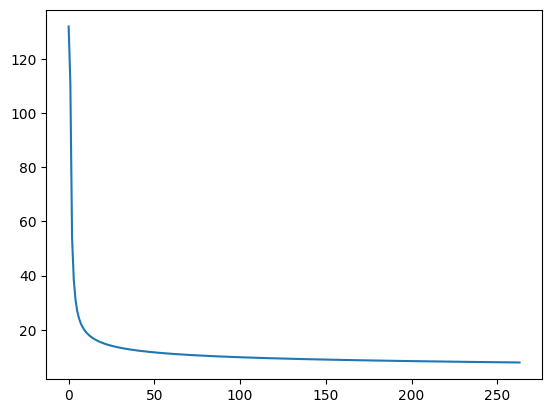

In [7]:
plt.plot(nwt.get_cost_hist())

## Using cross-validation Techniques

In [6]:
lrs = [0.01, 0.005, 0.003, 0.001]
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'violet', 'purple']

### Holdout Method with Batch Gradient Descent

In [7]:
hld_cv = crossValdAC.CrossVald(option='holdout')
gd_hld_train_costs, gd_hld_opt_model = hld_cv.fit(data_x, data_y, lr=lrs, max_iter=1000, iter_step=100, eps=1e-5)

Implementing Holdout Cross Validation.
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  32.576
Iteration   200 | Cost:  25.307
Iteration   300 | Cost:  22.035
Iteration   400 | Cost:  20.047
Iteration   500 | Cost:  18.664
Iteration   600 | Cost:  17.624
Iteration   700 | Cost:  16.802
Iteration   800 | Cost:  16.127
Iteration   900 | Cost:  15.560
Iteration  1000 | Cost:  15.074
F1-score: 0.9642857142857143
----------------- lr : 0.005 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  43.416
Iteration   200 | Cost:  32.758
Iteration   300 | Cost:  27.872
Iteration   400 | Cost:  24.936
Iteration   500 | Cost:  22.923
Iteration   600 | Cost:  21.430
Iteration   700 | Cost:  20.265
Iteration   800 | Cost:  19.322
Iteration   900 | Cost:  18.537
Iteration  1000 | Cost:  17.871
F1-score: 0.955223880597015
----------------- lr : 0.003 ----

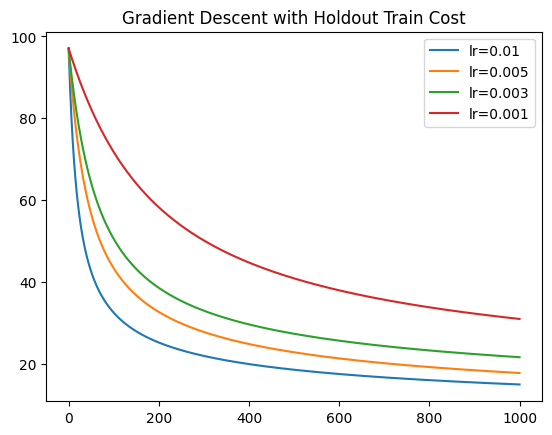

In [8]:
fig = plt.figure()
for i in range(len(gd_hld_train_costs)):
    plt.plot(gd_hld_train_costs[i], label=f'lr={lrs[i]}')
plt.legend()
plt.title('Gradient Descent with Holdout Train Cost')
plt.show()
fig.savefig('plots/gd_hld.png')

In [9]:
print(gd_hld_opt_model)

{'f1': 0.9393939393939394, 'lr': 0.003, 'w': array([[ 1.11599239],
       [-9.4373303 ],
       [ 6.48028247]])}


In [28]:
best_hld_gd = logRegAC.LogReg()
best_hld_gd.set_params(gd_hld_opt_model['w'])
hld_gd_cf_info = utilsAC.get_performance_measure(data_y, best_hld_gd.predict(utilsAC.normMinMax(data_x, mode='train')[0]))
hld_gd_cf_matrix = [[hld_gd_cf_info['tn'], hld_gd_cf_info['fn']], [hld_gd_cf_info['fp'], hld_gd_cf_info['tp']]]

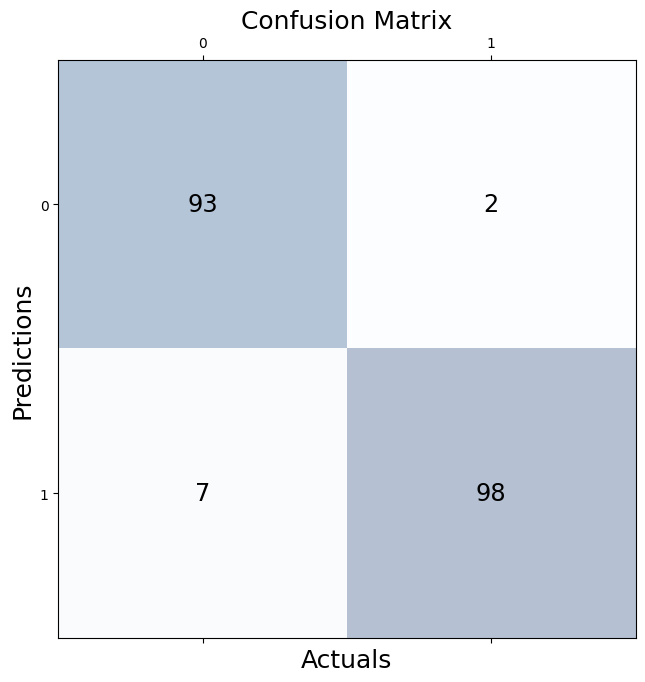

In [29]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(hld_gd_cf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(len(hld_gd_cf_matrix)):
    for j in range(len(hld_gd_cf_matrix[i])):
        ax.text(x=j, y=i,s=hld_gd_cf_matrix[i][j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Actuals', fontsize=18)
plt.ylabel('Predictions', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
fig.savefig('plots/hld_gd_confusion_matrix.png')

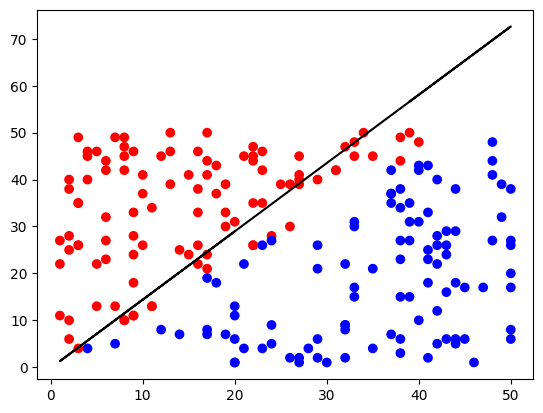

In [30]:
hld_gd_trained_weights = gd_hld_opt_model['w']
hld_gd_vals = np.dot(np.c_[np.ones((data_x.shape[0], 1)), data_x], hld_gd_trained_weights).flatten()
gd_plot_y = []
for i in range(len(hld_gd_vals)):
    gd_plot_y.append(-(hld_gd_trained_weights[0] + (hld_gd_trained_weights[1] * data_x.iloc[i, 0])) / hld_gd_trained_weights[2])
fig = plt.figure()
plt.plot(data_x.iloc[:, 0], gd_plot_y, c='black')
plt.scatter(data_x.iloc[:, 0], data_x.iloc[:, 1], c=data_y.map({0: 'blue', 1: 'red'}), marker='o')
plt.show()
fig.savefig('plots/hld_gd_data_dist_db.png')

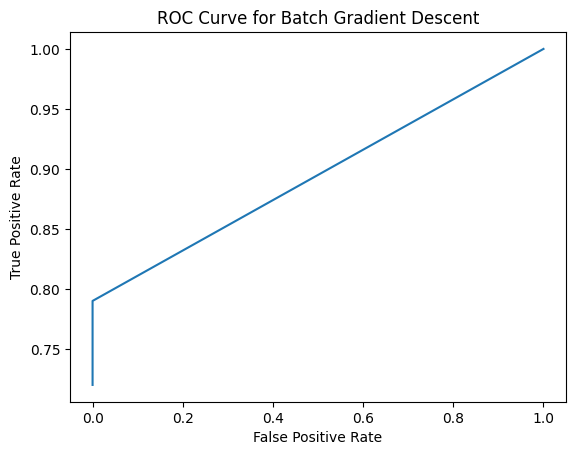

In [31]:
hld_gd_pred_prob = best_hld_gd.predict(data_x, prob=True)
thresh = np.arange(0, 1, 0.001)
gd_tpr = []
gd_fpr = []
for t in thresh:
    gd_pred = [1 if i >= t else 0 for i in hld_gd_pred_prob]
    gd_cf_info = utilsAC.get_performance_measure(data_y, gd_pred)
    tp = gd_cf_info['tp']
    fp = gd_cf_info['fp']
    tn = gd_cf_info['tn']
    fn = gd_cf_info['fn']
    gd_tpr.append(tp/(tp+fn))
    gd_fpr.append(fp/(fp+tn))
fig = plt.figure()
plt.plot(gd_fpr, gd_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Batch Gradient Descent')
plt.show()
fig.savefig('plots/hld_gd_roc.png')

### Holdout Method with Stochastic Gradient Descent

In [10]:
sgd_hld_train_costs, sgd_hld_opt_model = hld_cv.fit(data_x, data_y, lr=lrs, max_iter=1000, iter_step=100, eps=1e-5, stochGD=True)

Implementing Holdout Cross Validation.
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  29.901
Iteration   200 | Cost:  22.748
Iteration   300 | Cost:  19.616
Iteration   400 | Cost:  17.751
Iteration   500 | Cost:  16.472
Iteration   600 | Cost:  15.521
Iteration   700 | Cost:  14.775
Iteration   800 | Cost:  14.169
Iteration   900 | Cost:  13.663
Iteration  1000 | Cost:  13.232
F1-score: 0.912280701754386
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  41.647
Iteration   200 | Cost:  31.390
Iteration   300 | Cost:  26.722
Iteration   400 | Cost:  23.916
Iteration   500 | Cost:  21.987
Iteration   600 | Cost:  20.551
Iteration   700 | Cost:  19.426
Iteration   800 | Cost:  18.512
Iteration   900 | Cost:  17.749
Iteration  1000 | Cost:  17.098
F1-score: 0.923076923076923
----------------- lr : 0

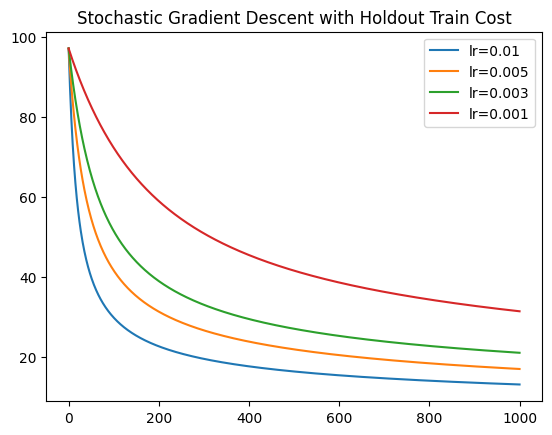

In [11]:
fig = plt.figure()
for i in range(len(sgd_hld_train_costs)):
    plt.plot(sgd_hld_train_costs[i], label=f'lr={lrs[i]}')
plt.legend()
plt.title('Stochastic Gradient Descent with Holdout Train Cost')
plt.show()
fig.savefig('plots/sgd_hld.png')

In [12]:
print(sgd_hld_opt_model)

{'f1': 0.912280701754386, 'lr': 0.01, 'w': array([[  1.55598289],
       [-14.60778706],
       [ 10.63711337]])}


In [32]:
best_hld_sgd = logRegAC.LogReg()
best_hld_sgd.set_params(sgd_hld_opt_model['w'])
hld_sgd_cf_info = utilsAC.get_performance_measure(data_y, best_hld_sgd.predict(utilsAC.normMinMax(data_x, mode='train')[0]))
hld_sgd_cf_matrix = [[hld_sgd_cf_info['tn'], hld_sgd_cf_info['fn']], [hld_sgd_cf_info['fp'], hld_sgd_cf_info['tp']]]

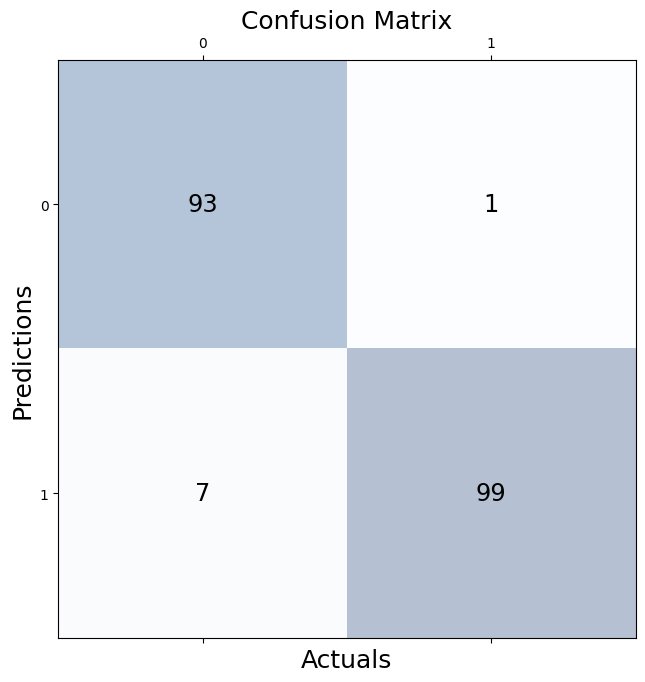

In [33]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(hld_sgd_cf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(len(hld_sgd_cf_matrix)):
    for j in range(len(hld_sgd_cf_matrix[i])):
        ax.text(x=j, y=i,s=hld_sgd_cf_matrix[i][j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Actuals', fontsize=18)
plt.ylabel('Predictions', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
fig.savefig('plots/hld_sgd_confusion_matrix.png')

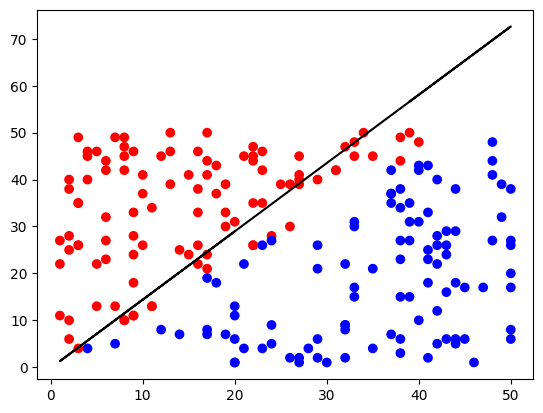

In [34]:
hld_sgd_trained_weights = sgd_hld_opt_model['w']
hld_sgd_vals = np.dot(np.c_[np.ones((data_x.shape[0], 1)), data_x], hld_sgd_trained_weights).flatten()
sgd_plot_y = []
for i in range(len(hld_gd_vals)):
    sgd_plot_y.append(-(hld_sgd_trained_weights[0] + (hld_sgd_trained_weights[1] * data_x.iloc[i, 0])) / hld_sgd_trained_weights[2])
fig = plt.figure()
plt.plot(data_x.iloc[:, 0], gd_plot_y, c='black')
plt.scatter(data_x.iloc[:, 0], data_x.iloc[:, 1], c=data_y.map({0: 'blue', 1: 'red'}), marker='o')
plt.show()
fig.savefig('plots/hld_sgd_data_dist_db.png')

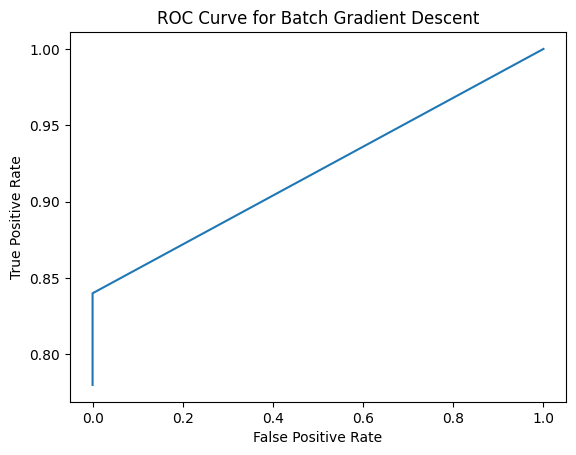

In [35]:
hld_sgd_pred_prob = best_hld_sgd.predict(data_x, prob=True)
thresh = np.arange(0, 1, 0.001)
sgd_tpr = []
sgd_fpr = []
for t in thresh:
    sgd_pred = [1 if i >= t else 0 for i in hld_sgd_pred_prob]
    sgd_cf_info = utilsAC.get_performance_measure(data_y, sgd_pred)
    tp = sgd_cf_info['tp']
    fp = sgd_cf_info['fp']
    tn = sgd_cf_info['tn']
    fn = sgd_cf_info['fn']
    sgd_tpr.append(tp/(tp+fn))
    sgd_fpr.append(fp/(fp+tn))
fig = plt.figure()
plt.plot(sgd_fpr, sgd_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Batch Gradient Descent')
plt.show()
fig.savefig('plots/hld_sgd_roc.png')

### Monte Carlo Cross-Validation with Batch Gradient Descent

In [13]:
montc_cv = crossValdAC.CrossVald(option='monte_carlo', monte_carlo=5)
gd_montc_train_costs, gd_montc_opt_model = montc_cv.fit(data_x, data_y, lr=lrs, max_iter=1000, iter_step=100, eps=1e-5)

Implementing Monte Carlo Cross Validation.
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  31.129
Iteration   200 | Cost:  24.024
Iteration   300 | Cost:  20.917
Iteration   400 | Cost:  19.076
Iteration   500 | Cost:  17.821
Iteration   600 | Cost:  16.893
Iteration   700 | Cost:  16.170
Iteration   800 | Cost:  15.585
Iteration   900 | Cost:  15.098
Iteration  1000 | Cost:  14.685
F1-score: 1.0
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  30.048
Iteration   200 | Cost:  22.906
Iteration   300 | Cost:  19.810
Iteration   400 | Cost:  17.980
Iteration   500 | Cost:  16.733
Iteration   600 | Cost:  15.809
Iteration   700 | Cost:  15.087
Iteration   800 | Cost:  14.501
Iteration   900 | Cost:  14.012
Iteration  1000 | Cost:  13.595
F1-score: 0.9655172413793104
----------------- lr : 0.01 ----------------

In [14]:
print(gd_montc_opt_model)

{'f1': 0.9462574416839145, 'lr': 0.005, 'w': array([[  0.7687029 ],
       [-10.91755832],
       [  8.64396284]])}


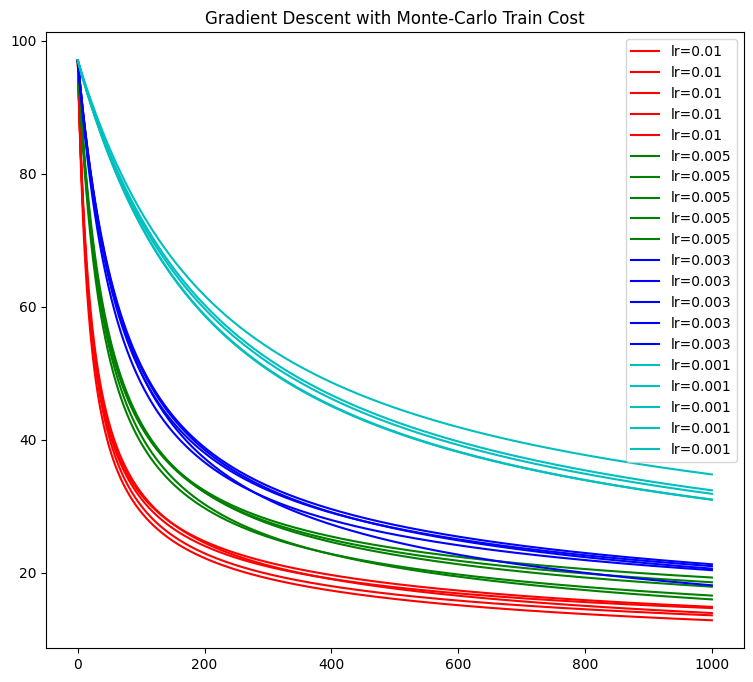

In [15]:
fig = plt.figure(figsize=(9, 8))
for i in range(len(gd_montc_train_costs)):
    for j in range(len(gd_montc_train_costs[i])):
        plt.plot(gd_montc_train_costs[i][j], label=f'lr={lrs[i]}', color=colors[i])
plt.legend()
plt.title('Gradient Descent with Monte-Carlo Train Cost')
plt.show()
fig.savefig('plots/gd_montc.png')

### Monte Carlo Cross-Validation with Stochastic Gradient Descent

In [16]:
sgd_montc_train_costs, sgd_montc_opt_model = montc_cv.fit(data_x, data_y, lr=lrs, max_iter=1000, iter_step=100, eps=1e-5, stochGD=True)

Implementing Monte Carlo Cross Validation.
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  32.598
Iteration   200 | Cost:  25.184
Iteration   300 | Cost:  21.876
Iteration   400 | Cost:  19.882
Iteration   500 | Cost:  18.503
Iteration   600 | Cost:  17.472
Iteration   700 | Cost:  16.660
Iteration   800 | Cost:  15.997
Iteration   900 | Cost:  15.441
Iteration  1000 | Cost:  14.966
F1-score: 0.9600000000000001
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  33.249
Iteration   200 | Cost:  26.107
Iteration   300 | Cost:  22.902
Iteration   400 | Cost:  20.959
Iteration   500 | Cost:  19.609
Iteration   600 | Cost:  18.596
Iteration   700 | Cost:  17.794
Iteration   800 | Cost:  17.138
Iteration   900 | Cost:  16.586
Iteration  1000 | Cost:  16.113
F1-score: 1.0
----------------- lr : 0.01 ------

In [17]:
print(sgd_montc_opt_model)

{'f1': 0.9542057455751063, 'lr': 0.001, 'w': array([[ 0.9022078 ],
       [-5.96250074],
       [ 4.12194573]])}


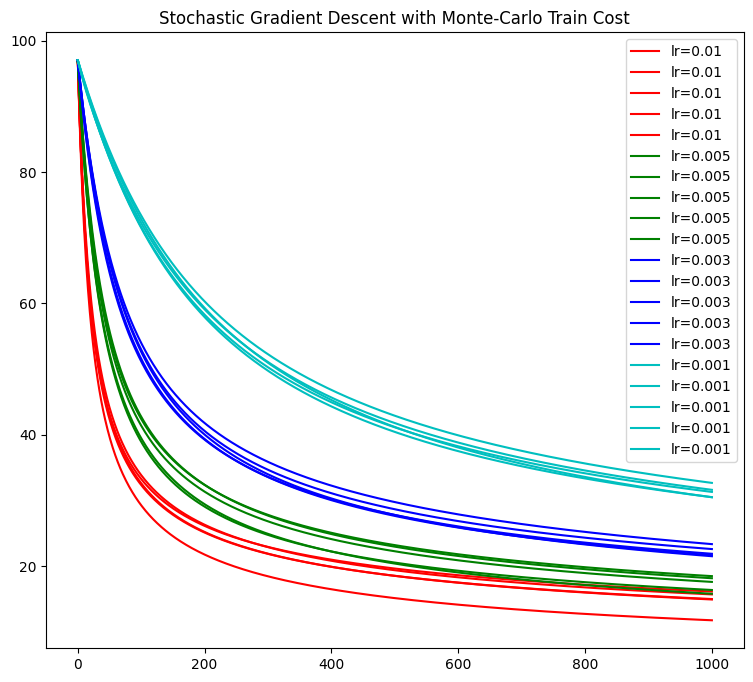

In [18]:
fig = plt.figure(figsize=(9, 8))
for i in range(len(sgd_montc_train_costs)):
    for j in range(len(sgd_montc_train_costs[i])):
        plt.plot(sgd_montc_train_costs[i][j], label=f'lr={lrs[i]}', color=colors[i])
plt.legend()
plt.title('Stochastic Gradient Descent with Monte-Carlo Train Cost')
plt.show()
fig.savefig('plots/sgd_montc.png')

In [19]:
kfold_cv = crossValdAC.CrossVald(option='k_fold', k_fold=6)
gd_kfold_train_costs, gd_kfold_opt_model = kfold_cv.fit(data_x, data_y, lr=lrs, max_iter=1000, iter_step=100, eps=1e-5)

Implementing K-Fold Cross Validation.
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  37.554
Iteration   200 | Cost:  29.508
Iteration   300 | Cost:  25.898
Iteration   400 | Cost:  23.710
Iteration   500 | Cost:  22.193
Iteration   600 | Cost:  21.055
Iteration   700 | Cost:  20.159
Iteration   800 | Cost:  19.426
Iteration   900 | Cost:  18.812
Iteration  1000 | Cost:  18.287
F1-score: 1.0
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  34.524
Iteration   200 | Cost:  26.848
Iteration   300 | Cost:  23.423
Iteration   400 | Cost:  21.353
Iteration   500 | Cost:  19.918
Iteration   600 | Cost:  18.843
Iteration   700 | Cost:  17.996
Iteration   800 | Cost:  17.304
Iteration   900 | Cost:  16.723
Iteration  1000 | Cost:  16.227
F1-score: 0.9696969696969697
----------------- lr : 0.01 -----------------
I

/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclud

Iteration  1000 | Cost:  14.779
F1-score: 0.9375
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  34.994
Iteration   200 | Cost:  27.113
Iteration   300 | Cost:  23.608
Iteration   400 | Cost:  21.498
Iteration   500 | Cost:  20.041
Iteration   600 | Cost:  18.953
Iteration   700 | Cost:  18.098
Iteration   800 | Cost:  17.401
Iteration   900 | Cost:  16.818
Iteration  1000 | Cost:  16.320
F1-score: 1.0
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  114.369
Iteration   100 | Cost:  34.087
Iteration   200 | Cost:  26.409
Iteration   300 | Cost:  22.961
Iteration   400 | Cost:  20.867
Iteration   500 | Cost:  19.411
Iteration   600 | Cost:  18.317
Iteration   700 | Cost:  17.453
Iteration   800 | Cost:  16.746
Iteration   900 | Cost:  16.152
Iteration  1000 | Cost:  15.643
F1-score: 0.967741935483871
----------------- lr : 0.005 --------

/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclud

Iteration   100 | Cost:  46.799
Iteration   200 | Cost:  35.348
Iteration   300 | Cost:  30.223
Iteration   400 | Cost:  27.166
Iteration   500 | Cost:  25.075
Iteration   600 | Cost:  23.525
Iteration   700 | Cost:  22.315
Iteration   800 | Cost:  21.334
Iteration   900 | Cost:  20.516
Iteration  1000 | Cost:  19.821
F1-score: 0.9411764705882353
----------------- lr : 0.005 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  47.591
Iteration   200 | Cost:  35.828
Iteration   300 | Cost:  30.498
Iteration   400 | Cost:  27.299
Iteration   500 | Cost:  25.103
Iteration   600 | Cost:  23.473
Iteration   700 | Cost:  22.198
Iteration   800 | Cost:  21.163
Iteration   900 | Cost:  20.301
Iteration  1000 | Cost:  19.568
F1-score: 0.9473684210526316
----------------- lr : 0.005 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  44.456
Iteration   200 | Cost:  33.678
Iter

/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclud

Iteration   100 | Cost:  58.387
Iteration   200 | Cost:  44.882
Iteration   300 | Cost:  38.604
Iteration   400 | Cost:  34.830
Iteration   500 | Cost:  32.244
Iteration   600 | Cost:  30.328
Iteration   700 | Cost:  28.833
Iteration   800 | Cost:  27.621
Iteration   900 | Cost:  26.612
Iteration  1000 | Cost:  25.753
F1-score: 1.0
----------------- lr : 0.003 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  58.781
Iteration   200 | Cost:  45.068
Iteration   300 | Cost:  38.646
Iteration   400 | Cost:  34.773
Iteration   500 | Cost:  32.117
Iteration   600 | Cost:  30.149
Iteration   700 | Cost:  28.613
Iteration   800 | Cost:  27.369
Iteration   900 | Cost:  26.333
Iteration  1000 | Cost:  25.451
F1-score: 1.0
----------------- lr : 0.003 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  58.507
Iteration   200 | Cost:  44.811
Iteration   300 | Cost:  38.396
It

/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclud

Iteration   200 | Cost:  40.695
Iteration   300 | Cost:  34.447
Iteration   400 | Cost:  30.721
Iteration   500 | Cost:  28.182
Iteration   600 | Cost:  26.309
Iteration   700 | Cost:  24.852
Iteration   800 | Cost:  23.675
Iteration   900 | Cost:  22.697
Iteration  1000 | Cost:  21.867
F1-score: 0.9523809523809523
----------------- lr : 0.003 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  114.369
Iteration   100 | Cost:  56.326
Iteration   200 | Cost:  42.548
Iteration   300 | Cost:  36.186
Iteration   400 | Cost:  32.387
Iteration   500 | Cost:  29.803
Iteration   600 | Cost:  27.900
Iteration   700 | Cost:  26.423
Iteration   800 | Cost:  25.233
Iteration   900 | Cost:  24.246
Iteration  1000 | Cost:  23.410
F1-score: 0.9444444444444444
----------------- lr : 0.001 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  82.726
Iteration   200 | Cost:  66.690
Iteration   300 | Cost:  57.407
Iter

/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclud

Iteration   300 | Cost:  56.692
Iteration   400 | Cost:  50.628
Iteration   500 | Cost:  46.333
Iteration   600 | Cost:  43.108
Iteration   700 | Cost:  40.580
Iteration   800 | Cost:  38.534
Iteration   900 | Cost:  36.837
Iteration  1000 | Cost:  35.399
F1-score: 1.0
----------------- lr : 0.001 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  82.637
Iteration   200 | Cost:  66.317
Iteration   300 | Cost:  56.844
Iteration   400 | Cost:  50.633
Iteration   500 | Cost:  46.210
Iteration   600 | Cost:  42.872
Iteration   700 | Cost:  40.245
Iteration   800 | Cost:  38.111
Iteration   900 | Cost:  36.335
Iteration  1000 | Cost:  34.828
F1-score: 0.9333333333333333
----------------- lr : 0.001 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  84.286
Iteration   200 | Cost:  68.294
Iteration   300 | Cost:  58.874
Iteration   400 | Cost:  52.671
Iteration   500 | C

/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


In [20]:
print(gd_kfold_opt_model)

{'f1': 0.9490610584432094, 'lr': 0.001, 'w': array([[ 0.60366409],
       [-6.21438049],
       [ 4.62750231]])}


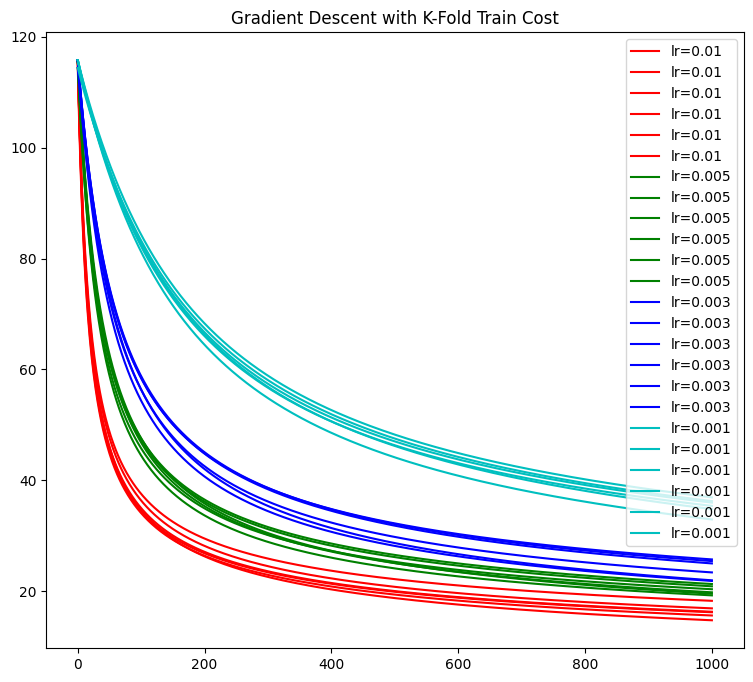

In [21]:
fig = plt.figure(figsize=(9, 8))
for i in range(len(gd_kfold_train_costs)):
    for j in range(len(gd_kfold_train_costs[i])):
        plt.plot(gd_kfold_train_costs[i][j], label=f'lr={lrs[i]}', color=colors[i])
plt.legend()
plt.title('Gradient Descent with K-Fold Train Cost')
plt.show()
fig.savefig('plots/gd_kfold.png')

In [22]:
sgd_kfold_train_costs, sgd_kfold_opt_model = kfold_cv.fit(data_x, data_y, lr=lrs, max_iter=1000, iter_step=100, eps=1e-5, stochGD=True)

Implementing K-Fold Cross Validation.
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  35.563
Iteration   200 | Cost:  27.727


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  24.234
Iteration   400 | Cost:  22.120
Iteration   500 | Cost:  20.652
Iteration   600 | Cost:  19.549
Iteration   700 | Cost:  18.678
Iteration   800 | Cost:  17.964
Iteration   900 | Cost:  17.364
Iteration  1000 | Cost:  16.849
F1-score: 0.9473684210526316
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  35.524


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  27.470
Iteration   300 | Cost:  23.846
Iteration   400 | Cost:  21.651
Iteration   500 | Cost:  20.132
Iteration   600 | Cost:  18.996
Iteration   700 | Cost:  18.103
Iteration   800 | Cost:  17.376
Iteration   900 | Cost:  16.768
Iteration  1000 | Cost:  16.249
F1-score: 0.972972972972973
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  34.387
Iteration   200 | Cost:  26.382
Iteration   300 | Cost:  22.771
Iteration   400 | Cost:  20.576
Iteration   500 | Cost:  19.051
Iteration   600 | Cost:  17.907
Iteration   700 | Cost:  17.006
Iteration   800 | Cost:  16.271
Iteration   900 | Cost:  15.656
Iteration  1000 | Cost:  15.130
F1-score: 0.972972972972973
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  36.521
Iteration   200 | Cost:  28.554


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  24.976
Iteration   400 | Cost:  22.806
Iteration   500 | Cost:  21.300
Iteration   600 | Cost:  20.170
Iteration   700 | Cost:  19.278
Iteration   800 | Cost:  18.549
Iteration   900 | Cost:  17.938
Iteration  1000 | Cost:  17.415
F1-score: 0.9696969696969697
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  35.916


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  28.026
Iteration   300 | Cost:  24.526
Iteration   400 | Cost:  22.422
Iteration   500 | Cost:  20.969
Iteration   600 | Cost:  19.884
Iteration   700 | Cost:  19.030
Iteration   800 | Cost:  18.334
Iteration   900 | Cost:  17.751
Iteration  1000 | Cost:  17.253
F1-score: 1.0
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  114.369


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  34.440
Iteration   200 | Cost:  26.251
Iteration   300 | Cost:  22.620
Iteration   400 | Cost:  20.439
Iteration   500 | Cost:  18.935
Iteration   600 | Cost:  17.813
Iteration   700 | Cost:  16.931
Iteration   800 | Cost:  16.213
Iteration   900 | Cost:  15.612
Iteration  1000 | Cost:  15.099
F1-score: 0.9696969696969697
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  46.977
Iteration   200 | Cost:  36.010


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  31.088
Iteration   400 | Cost:  28.135
Iteration   500 | Cost:  26.104
Iteration   600 | Cost:  24.590
Iteration   700 | Cost:  23.401
Iteration   800 | Cost:  22.434
Iteration   900 | Cost:  21.624
Iteration  1000 | Cost:  20.933
F1-score: 1.0
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  48.501


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  36.836
Iteration   300 | Cost:  31.512
Iteration   400 | Cost:  28.295
Iteration   500 | Cost:  26.075
Iteration   600 | Cost:  24.419
Iteration   700 | Cost:  23.119
Iteration   800 | Cost:  22.063
Iteration   900 | Cost:  21.180
Iteration  1000 | Cost:  20.428
F1-score: 0.9444444444444444
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  46.435
Iteration   200 | Cost:  35.390
Iteration   300 | Cost:  30.516
Iteration   400 | Cost:  27.627
Iteration   500 | Cost:  25.655
Iteration   600 | Cost:  24.194
Iteration   700 | Cost:  23.053
Iteration   800 | Cost:  22.126
Iteration   900 | Cost:  21.353
Iteration  1000 | Cost:  20.695
F1-score: 1.0
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  47.355
Iteration   200 | Cost:  35.993


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  30.853
Iteration   400 | Cost:  27.763
Iteration   500 | Cost:  25.637
Iteration   600 | Cost:  24.053
Iteration   700 | Cost:  22.811
Iteration   800 | Cost:  21.800
Iteration   900 | Cost:  20.956
Iteration  1000 | Cost:  20.236
F1-score: 0.9714285714285714
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  44.566


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  33.380
Iteration   300 | Cost:  28.419
Iteration   400 | Cost:  25.473
Iteration   500 | Cost:  23.462
Iteration   600 | Cost:  21.974
Iteration   700 | Cost:  20.814
Iteration   800 | Cost:  19.874
Iteration   900 | Cost:  19.092
Iteration  1000 | Cost:  18.427
F1-score: 0.9411764705882353
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  114.369


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  45.870
Iteration   200 | Cost:  34.978
Iteration   300 | Cost:  30.142
Iteration   400 | Cost:  27.274
Iteration   500 | Cost:  25.321
Iteration   600 | Cost:  23.878
Iteration   700 | Cost:  22.753
Iteration   800 | Cost:  21.844
Iteration   900 | Cost:  21.087
Iteration  1000 | Cost:  20.443
F1-score: 0.9655172413793104
----------------- lr : 0.003 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  55.034
Iteration   200 | Cost:  41.135


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  34.759
Iteration   400 | Cost:  30.962
Iteration   500 | Cost:  28.383
Iteration   600 | Cost:  26.485
Iteration   700 | Cost:  25.013
Iteration   800 | Cost:  23.826
Iteration   900 | Cost:  22.843
Iteration  1000 | Cost:  22.011
F1-score: 0.9500000000000001
----------------- lr : 0.003 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  57.424


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  43.673
Iteration   300 | Cost:  37.237
Iteration   400 | Cost:  33.342
Iteration   500 | Cost:  30.660
Iteration   600 | Cost:  28.663
Iteration   700 | Cost:  27.099
Iteration   800 | Cost:  25.827
Iteration   900 | Cost:  24.766
Iteration  1000 | Cost:  23.861
F1-score: 0.896551724137931
----------------- lr : 0.003 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  56.571
Iteration   200 | Cost:  42.980
Iteration   300 | Cost:  36.746
Iteration   400 | Cost:  33.030
Iteration   500 | Cost:  30.502
Iteration   600 | Cost:  28.638
Iteration   700 | Cost:  27.191
Iteration   800 | Cost:  26.022
Iteration   900 | Cost:  25.053
Iteration  1000 | Cost:  24.230
F1-score: 0.972972972972973
----------------- lr : 0.003 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  57.845
Iteration   200 | Cost:  44.123


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  37.728
Iteration   400 | Cost:  33.876
Iteration   500 | Cost:  31.232
Iteration   600 | Cost:  29.272
Iteration   700 | Cost:  27.739
Iteration   800 | Cost:  26.496
Iteration   900 | Cost:  25.460
Iteration  1000 | Cost:  24.578
F1-score: 1.0
----------------- lr : 0.003 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  57.875


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  43.931
Iteration   300 | Cost:  37.427
Iteration   400 | Cost:  33.516
Iteration   500 | Cost:  30.841
Iteration   600 | Cost:  28.861
Iteration   700 | Cost:  27.319
Iteration   800 | Cost:  26.071
Iteration   900 | Cost:  25.034
Iteration  1000 | Cost:  24.153
F1-score: 0.9375
----------------- lr : 0.003 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  114.369


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  57.667
Iteration   200 | Cost:  43.687
Iteration   300 | Cost:  37.172
Iteration   400 | Cost:  33.266
Iteration   500 | Cost:  30.602
Iteration   600 | Cost:  28.636
Iteration   700 | Cost:  27.107
Iteration   800 | Cost:  25.874
Iteration   900 | Cost:  24.851
Iteration  1000 | Cost:  23.984
F1-score: 0.9696969696969697
----------------- lr : 0.001 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  82.742
Iteration   200 | Cost:  66.509


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  57.150
Iteration   400 | Cost:  51.063
Iteration   500 | Cost:  46.761
Iteration   600 | Cost:  43.538
Iteration   700 | Cost:  41.017
Iteration   800 | Cost:  38.980
Iteration   900 | Cost:  37.292
Iteration  1000 | Cost:  35.863
F1-score: 1.0
----------------- lr : 0.001 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  83.131


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  67.042
Iteration   300 | Cost:  57.744
Iteration   400 | Cost:  51.689
Iteration   500 | Cost:  47.407
Iteration   600 | Cost:  44.197
Iteration   700 | Cost:  41.687
Iteration   800 | Cost:  39.658
Iteration   900 | Cost:  37.978
Iteration  1000 | Cost:  36.557
F1-score: 1.0
----------------- lr : 0.001 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  81.952
Iteration   200 | Cost:  65.560
Iteration   300 | Cost:  56.178
Iteration   400 | Cost:  50.096
Iteration   500 | Cost:  45.805
Iteration   600 | Cost:  42.592
Iteration   700 | Cost:  40.081
Iteration   800 | Cost:  38.052
Iteration   900 | Cost:  36.372
Iteration  1000 | Cost:  34.952
F1-score: 0.967741935483871
----------------- lr : 0.001 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  83.585
Iteration   200 | Cost:  67.321


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  57.774
Iteration   400 | Cost:  51.486
Iteration   500 | Cost:  47.000
Iteration   600 | Cost:  43.612
Iteration   700 | Cost:  40.946
Iteration   800 | Cost:  38.781
Iteration   900 | Cost:  36.980
Iteration  1000 | Cost:  35.451
F1-score: 0.9375
----------------- lr : 0.001 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  82.564


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  66.282
Iteration   300 | Cost:  56.814
Iteration   400 | Cost:  50.592
Iteration   500 | Cost:  46.151
Iteration   600 | Cost:  42.792
Iteration   700 | Cost:  40.143
Iteration   800 | Cost:  37.988
Iteration   900 | Cost:  36.192
Iteration  1000 | Cost:  34.665
F1-score: 0.9302325581395349
----------------- lr : 0.001 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  114.369


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  83.124
Iteration   200 | Cost:  67.227
Iteration   300 | Cost:  57.839
Iteration   400 | Cost:  51.625
Iteration   500 | Cost:  47.173
Iteration   600 | Cost:  43.801
Iteration   700 | Cost:  41.142
Iteration   800 | Cost:  38.977
Iteration   900 | Cost:  37.174
Iteration  1000 | Cost:  35.641
F1-score: 0.9473684210526316


In [23]:
print(sgd_kfold_opt_model)

{'f1': 0.9544536111346457, 'lr': 0.003, 'w': array([[ 0.5498387 ],
       [-9.61713999],
       [ 7.97343608]])}


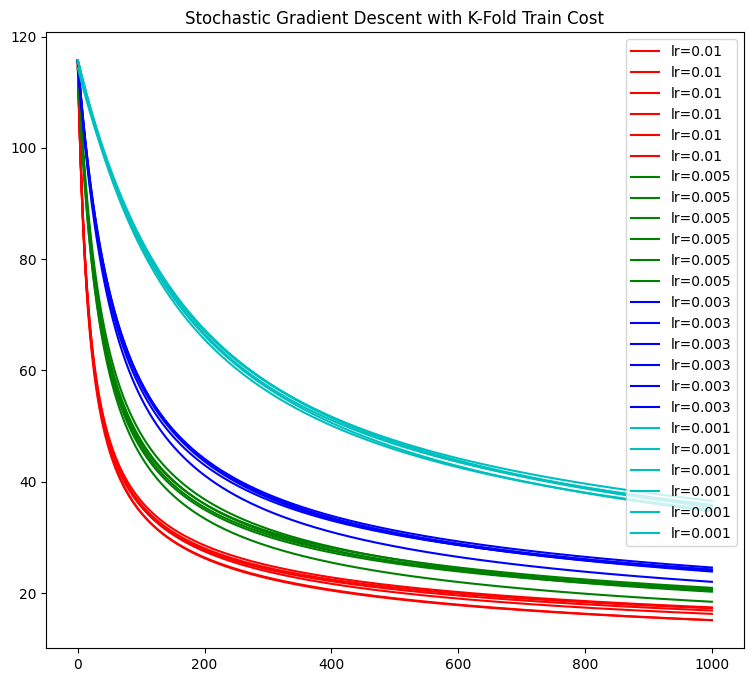

In [24]:
fig = plt.figure(figsize=(9, 8))
for i in range(len(sgd_kfold_train_costs)):
    for j in range(len(sgd_kfold_train_costs[i])):
        plt.plot(sgd_kfold_train_costs[i][j], label=f'lr={lrs[i]}', color=colors[i])
plt.legend()
plt.title('Stochastic Gradient Descent with K-Fold Train Cost')
plt.show()
fig.savefig('plots/sgd_kfold.png')

## Batch Gradient Descent

In [49]:
logReg1 = logRegAC.LogReg(lr=0.01, max_iter=1000)
logReg1.fit(train_x, train_y, iter_step=100)
pred = logReg1.predict(test_x)
print('F1 Score: ', utilsAC.get_performance_measure(test_y, pred)['f1'])

Implementing Batch Gradient Descent.
Iteration     0 | Cost:  110.904
Iteration   100 | Cost:  35.147
Iteration   200 | Cost:  27.306
Iteration   300 | Cost:  23.777
Iteration   400 | Cost:  21.637
Iteration   500 | Cost:  20.152
Iteration   600 | Cost:  19.039
Iteration   700 | Cost:  18.160
Iteration   800 | Cost:  17.443
Iteration   900 | Cost:  16.841
Iteration  1000 | Cost:  16.327
F1 Score:  0.9787234042553191


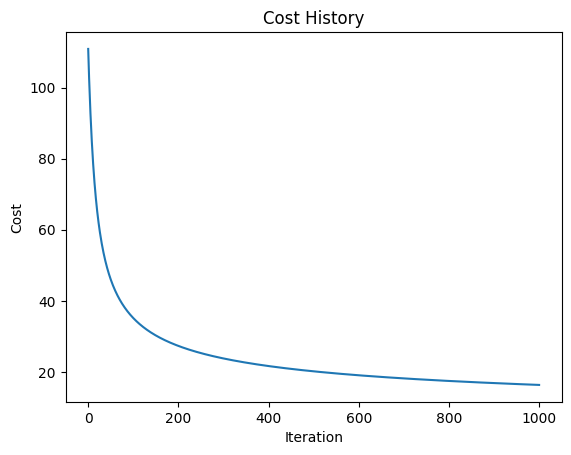

In [50]:
fig = plt.figure()
plt.plot(logReg1.get_cost_hist())
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost History')
plt.show()
fig.savefig('plots/gd_cost_hist.png')

In [51]:
gd_trained_weights = logReg1.get_params()
print(f'Trained Weights: {gd_trained_weights}')
gd_cf_info = utilsAC.get_performance_measure(data_y, logReg1.predict(utilsAC.normMinMax(data_x, mode='train')[0]))
gd_cf_matrix = [[gd_cf_info['tn'], gd_cf_info['fn']], [gd_cf_info['fp'], gd_cf_info['tp']]]

Trained Weights: [[  0.64953436]
 [-14.94721818]
 [ 12.24130375]]


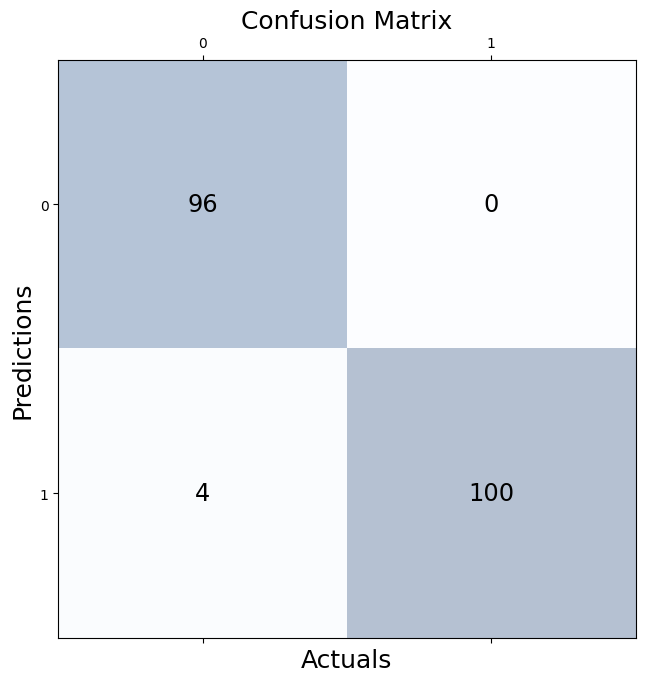

In [52]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(gd_cf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(len(gd_cf_matrix)):
    for j in range(len(gd_cf_matrix[i])):
        ax.text(x=j, y=i,s=gd_cf_matrix[i][j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Actuals', fontsize=18)
plt.ylabel('Predictions', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
fig.savefig('plots/gd_confusion_matrix.png')

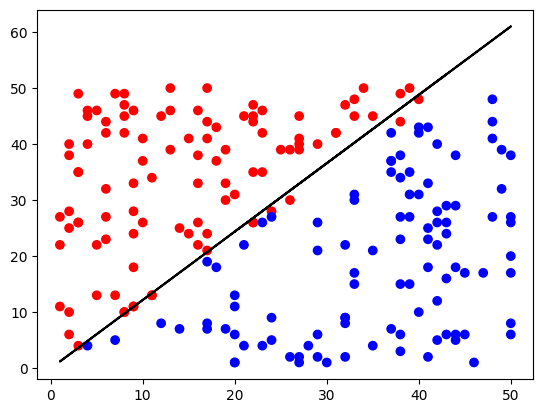

In [53]:
gd_vals = np.dot(np.c_[np.ones((data_x.shape[0], 1)), data_x], gd_trained_weights).flatten()
gd_plot_y = []
for i in range(len(gd_vals)):
    gd_plot_y.append(-(gd_trained_weights[0] + (gd_trained_weights[1] * data_x.iloc[i, 0])) / gd_trained_weights[2])
fig = plt.figure()
plt.plot(data_x.iloc[:, 0], gd_plot_y, c='black')
plt.scatter(data_x.iloc[:, 0], data_x.iloc[:, 1], c=data_y.map({0: 'blue', 1: 'red'}), marker='o')
plt.show()
fig.savefig('plots/gd_data_dist_db.png')

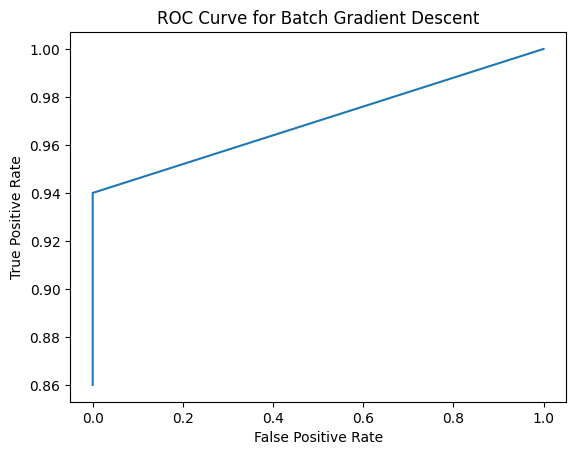

In [54]:
gd_pred_prob = logReg1.predict(data_x, prob=True)
thresh = np.arange(0, 1, 0.001)
gd_tpr = []
gd_fpr = []
for t in thresh:
    gd_pred = [1 if i >= t else 0 for i in gd_pred_prob]
    gd_cf_info = utilsAC.get_performance_measure(data_y, gd_pred)
    tp = gd_cf_info['tp']
    fp = gd_cf_info['fp']
    tn = gd_cf_info['tn']
    fn = gd_cf_info['fn']
    gd_tpr.append(tp/(tp+fn))
    gd_fpr.append(fp/(fp+tn))
fig = plt.figure()
plt.plot(gd_fpr, gd_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Batch Gradient Descent')
plt.show()
fig.savefig('plots/gd_roc.png')

## Stochastic Gradient Descent

In [55]:
logReg2 = logRegAC.LogReg(lr=0.01, max_iter=1000, stochGd=True)
logReg2.fit(train_x, train_y, iter_step=100)
pred2 = logReg2.predict(test_x)
print('F1 Score: ', utilsAC.get_performance_measure(test_y, pred2)['f1'])

Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  110.904
Iteration   100 | Cost:  35.252
Iteration   200 | Cost:  27.351
Iteration   300 | Cost:  23.803
Iteration   400 | Cost:  21.654
Iteration   500 | Cost:  20.163
Iteration   600 | Cost:  19.047
Iteration   700 | Cost:  18.166
Iteration   800 | Cost:  17.447
Iteration   900 | Cost:  16.844
Iteration  1000 | Cost:  16.329
F1 Score:  0.9787234042553191


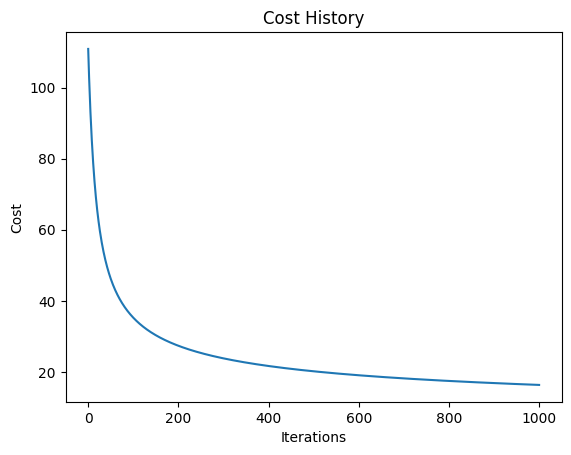

In [56]:
fig = plt.figure()
plt.plot(logReg2.get_cost_hist())
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost History')
plt.show()
fig.savefig('plots/sgd_cost_hist.png')

In [57]:
sgd_trained_weights = logReg2.get_params()
print(f'Trained Weights: {sgd_trained_weights}')
sgd_cf_info = utilsAC.get_performance_measure(data_y, logReg2.predict(utilsAC.normMinMax(data_x, mode='train')[0]))
sgd_cf_matrix = [[sgd_cf_info['tn'], sgd_cf_info['fn']], [sgd_cf_info['fp'], sgd_cf_info['tp']]]

Trained Weights: [[  0.6535831 ]
 [-14.94566011]
 [ 12.23862269]]


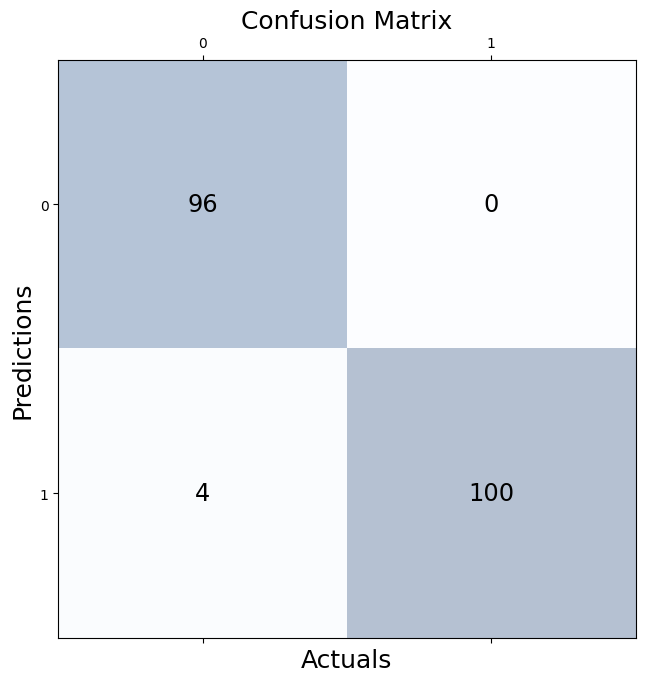

In [58]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(sgd_cf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(len(sgd_cf_matrix)):
    for j in range(len(sgd_cf_matrix[i])):
        ax.text(x=j, y=i,s=sgd_cf_matrix[i][j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Actuals', fontsize=18)
plt.ylabel('Predictions', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
fig.savefig('plots/sgd_confusion_matrix.png')

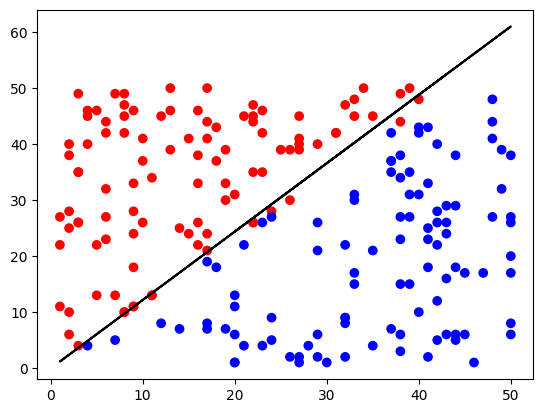

In [59]:
sgd_vals = np.dot(np.c_[np.ones((data_x.shape[0], 1)), data_x], sgd_trained_weights).flatten()
sgd_plot_y = []
for i in range(len(sgd_vals)):
    sgd_plot_y.append(-(sgd_trained_weights[0] + (sgd_trained_weights[1] * data_x.iloc[i, 0])) / sgd_trained_weights[2])
fig = plt.figure()
plt.plot(data_x.iloc[:, 0], sgd_plot_y, c='black')
plt.scatter(data_x.iloc[:, 0], data_x.iloc[:, 1], c=data_y.map({0: 'blue', 1: 'red'}), marker='o')
plt.show()
fig.savefig('plots/sgd_data_dist_db.png')

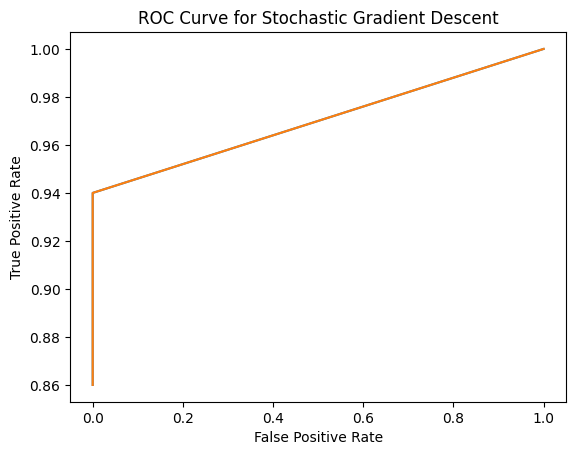

In [60]:
sgd_pred_prob = logReg2.predict(data_x, prob=True)
sgd_tpr = []
sgd_fpr = []
for t in thresh:
    sgd_pred = [1 if i >= t else 0 for i in sgd_pred_prob]
    sgd_cf_info = utilsAC.get_performance_measure(data_y, sgd_pred)
    tp = sgd_cf_info['tp']
    fp = sgd_cf_info['fp']
    tn = sgd_cf_info['tn']
    fn = sgd_cf_info['fn']
    sgd_tpr.append(tp/(tp+fn))
    sgd_fpr.append(fp/(fp+tn))
fig = plt.figure()
plt.plot(sgd_fpr, sgd_tpr)
plt.plot(gd_fpr, gd_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Stochastic Gradient Descent')
plt.show()
fig.savefig('plots/sgd_roc.png')